# Twin4Build: Neural policy control example

Welcome to this tutorial on using the Twin4Build package! In this notebook, you'll learn how to:
1. Load a simple t4b model
2. Define a neural network policy
3. Modify the model to incorporate the policy as a controller
4. Run a simulation with the neural policy controller

Let's get started!

## 1. Setup
First, let's install and import the necessary packages:

In [2]:
#%pip install git+https://github.com/JBjoernskov/Twin4Build.git # Uncomment in google colab
import twin4build as tb
import datetime
import twin4build.examples.utils as utils
import torch.nn as nn
import torch
import json
from dateutil.tz import gettz 
import twin4build.utils.plot.plot as plot
import twin4build.utils.input_output_types as tps


## 2. Creating the Model

In this example, we will use the one_room_example_model.xlsm file. 
This file contains a model of a single room with a space heater and supply and return ventilation.
We use the translation engine to automatically create the components and connections.

In [3]:

# Create a new model
model = tb.Model(id="neural_policy_example")
filename = utils.get_path(["parameter_estimation_example", "one_room_example_model.xlsm"])
model.load(semantic_model_filename=filename)


c:\project\t4b_fork\twin4build\twin4build\utils\mkdir_in_root.py:5: MainPathNotFound: Could not determine main module path, using temp dir: C:\Users\asces\AppData\Local\Temp
  current_dir = get_main_dir()


c:\project\t4b_fork\twin4build\twin4build\examples

Loading model...
   |___Reading semantic model...[OK]
   |___Drawing input object graph...[OK]
   |___Parsing semantic model...[OK]
   |___Drawing parsed object graph...[OK]
   |___Connecting components...[OK]
   |___Drawing system graph...[OK]
   |___Removing cycles...[OK]
   |___Drawing system graph without cycles...[OK]
   |___Determining execution order...[OK]
   |___Creating execution graph...[OK]
   |___Drawing execution graph...[OK]
   |___Loading parameters...[OK]
   |___Validating model...[WARNING]
   |   |
   |   |___|CLASS: BuildingSpace0AdjBoundaryOutdoorFMUSystem|ID: [020B][020B_space_heater]|: Missing values for the following parameter(s) to enable use of Simulator, Evaluator, and Monitor:
   |   |   |
   |   |   |___C_supply
   |   |   |___C_wall
   |   |   |___C_air
   |   |   |___C_boundary
   |   |   |___R_out
   |   |   |___R_in
   |   |   |___R_boundary
   |   |   |___f_wall
   |   |   |___f_air
   |   |   |___Q_oc

From the model validation above we see that different types of information is missing. 

We will add the missing information as per the parameter estimation example, here we will assume we know the right parameters for this model.

1. A method to inject the neural policy (For now with random weights)
2. A fcn function which adds the missing connections and schedules as well as injecting the neural policy

### 3. Incorporating the neural policy controller

Now that our model is set up, let's define a control strategy that might benefit from using a neural policy instead of classic controllers. The inputs of the policy could be:
- Outdoor temperature
- Supply air temperature
- Supply water temperature
- Space heater valve position
- Room supply damper position (In this case, supply and damper position are the same, so one signal provides enough information)
- Room CO2 level

The outputs would be:

- Temperature heating setpoint
- CO2 setpoint

We will use a policy previously trained with Reinforcement Learning to reduce energy usage in this model.

In [4]:
def insert_neural_policy_in_fcn(self:tb.Model, input_output_dictionary, policy_path=None):
        """
        The input/output dictionary contains information on the input and output signals of the controller.
        These signals must match the component and signal keys to replace in the model
        The input dictionary will have items like this:
            "component_key": {
                "component_output_signal_key": {
                    "min": 0,
                    "max": 1,
                    "description": "Description of the signal"
                }
            }
        Whilst the output items will have a similar structure but for the output signals:
            "component_key": {
                "component_input_signal_key": {
                    "min": 0,
                    "max": 1,
                    "description": "Description of the signal"
                }
            }
        Note that the input signals must contain the key for the output compoenent signal and the output signals must contain the key for the input component signal

        This function instantiates the controller and adds it to the model.
        Then it goes through the input dictionary adding connection to the input signals
        Then it goes through the output dictionary finding the corresponding existing connections, deleting the existing connections and adding the new connections
        """
        try:
            utils.validate_schema(input_output_dictionary)
        except Exception as e:
            print("Validation error:", e)
            return

        #Create the controller
        input_size = len(input_output_dictionary["input"])
        output_size = len(input_output_dictionary["output"])

        policy = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size),
            nn.Sigmoid()
        )

        #Load the policy model
        if policy_path is not None:
            policy.load_state_dict(torch.load(policy_path))

        neural_policy_controller = tb.NeuralPolicyControllerSystem(
            input_size = input_size,
            output_size = output_size,
            input_output_schema = input_output_dictionary,
            policy_model = policy,
            saveSimulationResult = True,
            id = "neural_controller"
        )

        #Find and remove the existing output connections and components
        for output_component_key in input_output_dictionary["output"]:
            receiving_component = self.component_dict[output_component_key]
            found = False  
            for connection_point in receiving_component.connectsAt:
                if connection_point.receiverPropertyName == input_output_dictionary["output"][output_component_key]["signal_key"]:
                    #Remove the connection(s) to the receiving component
                    for incoming_connection in connection_point.connectsSystemThrough:
                        sender_component = incoming_connection.connectsSystem
                        #If the sender component is not connected to any other component, remove it
                        if len(sender_component.connectedThrough) == 1:
                            self.remove_component(sender_component)
                        else:
                            self.remove_connection(sender_component, receiving_component, incoming_connection.senderPropertyName, connection_point.receiverPropertyName)
                    found = True 
                    break
            if not found:
                print(f"Could not find connection for {output_component_key} and {input_output_dictionary['output'][output_component_key]['signal_key']}")

       
        #Add the input connections
        
        for component_key in input_output_dictionary["input"]:
            try:
                sender_component = self.component_dict[component_key]
            except KeyError:
                print(f"Could not find component {component_key}")
                continue
            receiving_component = neural_policy_controller
            self.add_connection(
                sender_component,
                receiving_component,
                input_output_dictionary["input"][component_key]["signal_key"],
                "actualValue"
            )


        
        # Define the output dictionary for the NeuralController using a dictionary comprehension
        neural_policy_controller.output = {
            f"{component_key}_input_signal": tps.Scalar()
            for component_key in input_output_dictionary["output"]
        }

        # Loop through the components and add connections
        for component_key, output_info in input_output_dictionary["output"].items():
            output_key = f"{component_key}_input_signal"
            receiver_component = self.component_dict.get(component_key)
            if receiver_component is None:
                print(f"Could not find component {component_key}")
                continue
            self.add_connection(
                neural_policy_controller,
                receiver_component,
                output_key,  # Use the unique output_key for each connection
                output_info["signal_key"]
            )
        # Define a custom initial dictionary for the NeuralController outputs:
        custom_initial = {"neural_controller": {f"{component_key}_input_signal": tps.Scalar(0) for component_key in input_output_dictionary["output"]}}
        self.set_custom_initial_dict(custom_initial)


#### Setting model parameters
Obtained from the parameter estimation example

In [5]:
def set_model_parameters(self):
    # Get component references
    space = self.component_dict["[020B][020B_space_heater]"]
    heating_controller = self.component_dict["020B_temperature_heating_controller"]
    co2_controller = self.component_dict["020B_co2_controller"]
    space_heater_valve = self.component_dict["020B_space_heater_valve"]
    supply_damper = self.component_dict["020B_room_supply_damper"]
    exhaust_damper = self.component_dict["020B_room_exhaust_damper"]

    # Define parameters, components, and attributes
    parameters = [
        400,                     # CO2_start
        0.35,                    # fraRad_sh
        333.15,                  # T_a_nominal_sh
        303.15,                  # T_b_nominal_sh
        293.15,                  # TAir_nominal_sh
        1570814.0716295305,      # C_wall
        1301969.8981236944,      # C_air
        25903.054795409433,      # C_boundary
        0.036856517373434025,    # R_out
        0.017648740304878827,    # R_in
        0.0011821956470144748,   # R_boundary
        0.12398026888438979,     # f_wall
        0.507617122194916,       # f_air
        277.24361247360997,      # Q_occ_gain
        0.0010216031945522147,   # heating_controller kp
        7.0307710027994075,      # heating_controller Ti
        0.004852703638452023,    # co2_controller kp
        8.44932909032329,        # co2_controller Ti
        0.004898396001298374,    # m_flow_nominal
        0.002977689536109641,    # dpFixed_nominal
        21.025900835644723,      # T_boundary
        6.790610786857144,       # supply_damper a
        3.871299681159011,       # exhaust_damper a
        0.060068382408930844,    # infiltration
        3.1640648638260266e-05,  # CO2_occ_gain
        436.36769116771666,      # Q_flow_nominal_sh
        1.394916193442971,       # n_sh
        378.45481913618784       # C_supply
    ]

    components = [
        space, space, space, space, space,  # Initial space parameters
        space, space, space, space, space, space, space, space, space,  # Space parameters
        heating_controller, heating_controller,  # Heating controller parameters
        co2_controller, co2_controller,  # CO2 controller parameters
        space_heater_valve, space_heater_valve,  # Valve parameters
        space,  # T_boundary
        supply_damper, exhaust_damper,  # Damper parameters
        space, space, space, space, space  # Remaining space parameters
    ]

    attributes = [
        'CO2_start', 'fraRad_sh', 'T_a_nominal_sh', 'T_b_nominal_sh', 'TAir_nominal_sh',  # Initial space attributes
        'C_wall', 'C_air', 'C_boundary', 'R_out', 'R_in', 'R_boundary', 'f_wall', 'f_air', 'Q_occ_gain',
        'kp', 'Ti',  # Heating controller
        'kp', 'Ti',  # CO2 controller
        'm_flow_nominal', 'dpFixed_nominal',
        'T_boundary',
        'a', 'a',  # Dampers
        'infiltration', 'CO2_occ_gain', 'Q_flow_nominal_sh', 'n_sh', 'C_supply'
    ]

    self.set_parameters_from_array(parameters, components, attributes)

#### User-defined function adding missing connections
Also from the estimation parameter example, with the parameter setting and neural policy inserting functions now embedded into it.

In [6]:
def fcn(self):
    supply_water_schedule = tb.ScheduleSystem(
    weekDayRulesetDict = {
        "ruleset_default_value": 60,
        "ruleset_start_minute": [],
        "ruleset_end_minute": [],
        "ruleset_start_hour": [],
        "ruleset_end_hour": [],
        "ruleset_value": []
    },
    id="supply_water_schedule"
    )
    self.add_connection(supply_water_schedule, self.component_dict["[020B][020B_space_heater]"], "scheduleValue", "supplyWaterTemperature") # Add missing input
    self.component_dict["020B_temperature_sensor"].filename = utils.get_path(["parameter_estimation_example", "temperature_sensor.csv"])
    self.component_dict["020B_co2_sensor"].filename = utils.get_path(["parameter_estimation_example", "co2_sensor.csv"])
    self.component_dict["020B_valve_position_sensor"].filename = utils.get_path(["parameter_estimation_example", "valve_position_sensor.csv"])
    self.component_dict["020B_damper_position_sensor"].filename = utils.get_path(["parameter_estimation_example", "damper_position_sensor.csv"])
    self.component_dict["BTA004"].filename = utils.get_path(["parameter_estimation_example", "supply_air_temperature.csv"])
    self.component_dict["020B_co2_setpoint"].weekDayRulesetDict = {"ruleset_default_value": 900,
                                                                    "ruleset_start_minute": [],
                                                                    "ruleset_end_minute": [],
                                                                    "ruleset_start_hour": [],
                                                                    "ruleset_end_hour": [],
                                                                    "ruleset_value": []}
    self.component_dict["020B_temperature_heating_setpoint"].useFile = True
    self.component_dict["020B_temperature_heating_setpoint"].filename = utils.get_path(["parameter_estimation_example", "temperature_heating_setpoint.csv"])
    self.component_dict["outdoor_environment"].filename = utils.get_path(["parameter_estimation_example", "outdoor_environment.csv"])
    #Load the input/output dictionary from the file policy_input_output.json
    with open(utils.get_path(["neural_policy_controller_example", "policy_input_output.json"])) as f:
        input_output_dictionary = json.load(f)

    
    insert_neural_policy_in_fcn(self, input_output_dictionary)
    set_model_parameters(self)



Now we load the model:

In [7]:
model.load(semantic_model_filename=filename, fcn=fcn, verbose=False)


Loading model...
   |___Reading semantic model...[OK]
   |___Drawing input object graph...[OK]
   |___Parsing semantic model...[OK]
   |___Drawing parsed object graph...[OK]
   |___Connecting components...[OK]
   |___Applying user defined function...c:\project\t4b_fork\twin4build\twin4build\examples
c:\project\t4b_fork\twin4build\twin4build\examples
c:\project\t4b_fork\twin4build\twin4build\examples
c:\project\t4b_fork\twin4build\twin4build\examples
c:\project\t4b_fork\twin4build\twin4build\examples
c:\project\t4b_fork\twin4build\twin4build\examples
c:\project\t4b_fork\twin4build\twin4build\examples
c:\project\t4b_fork\twin4build\twin4build\examples
[OK]
   |___Drawing system graph...[OK]
   |___Removing cycles...[OK]
   |___Drawing system graph without cycles...[OK]
   |___Determining execution order...[OK]
   |___Creating execution graph...[OK]
   |___Drawing execution graph...[OK]
   |___Loading parameters...[OK]
   |___Validating model...[OK]
   |   |
   |
   |___Validated for Sim

### Visualizing the Model (not required)
We can visualize the model to see the components and connections.<br>
This is not required, but it can be helpful for debugging and for building the model.<br>
The nodes in the graph represent components, and the edges represent connections between components as defined earlier.
Note that a neural_policy_controller component is present an has a higher number of inputs and outputs

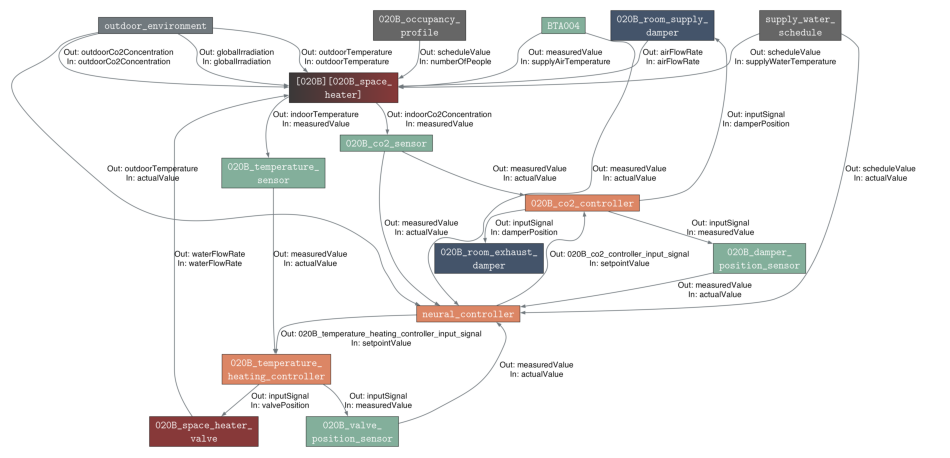

In [8]:
#Visualize the model
import matplotlib.pyplot as plt
import os
system_graph = os.path.join(model.graph_path, "system_graph.png")
image = plt.imread(system_graph)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.axis('off')
plt.show()


### 4. Run a simulation

100%|██████████| 1440/1440 [00:00<00:00, 2653.44it/s]


Simulation completed successfully!


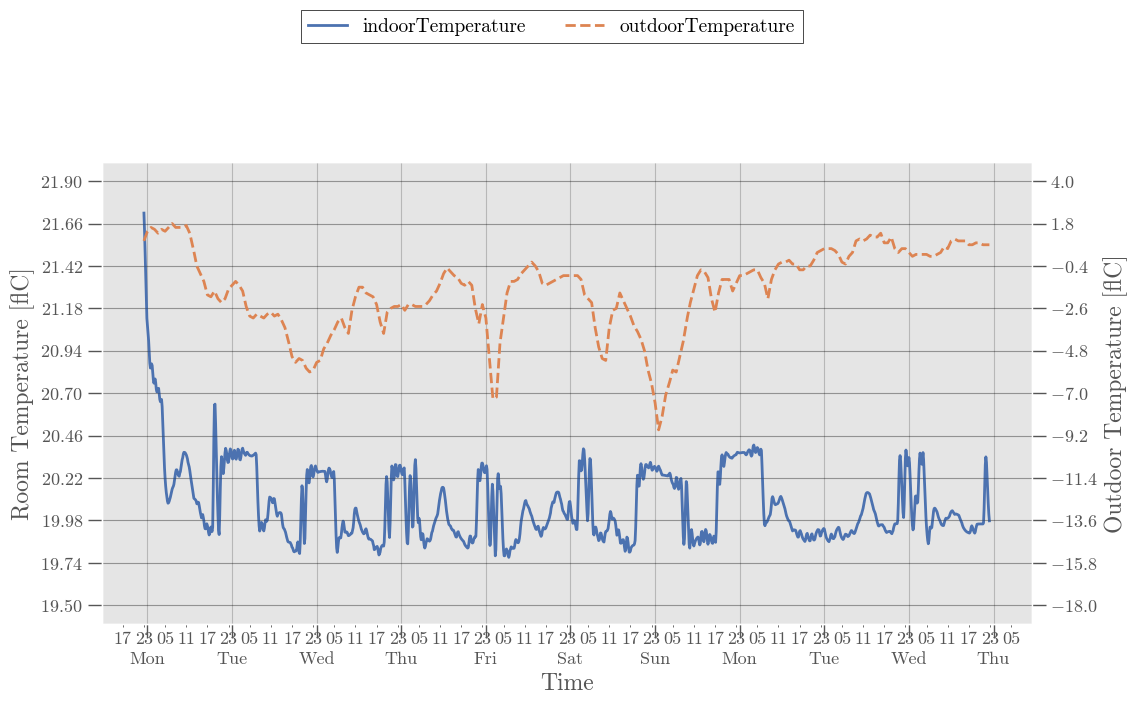

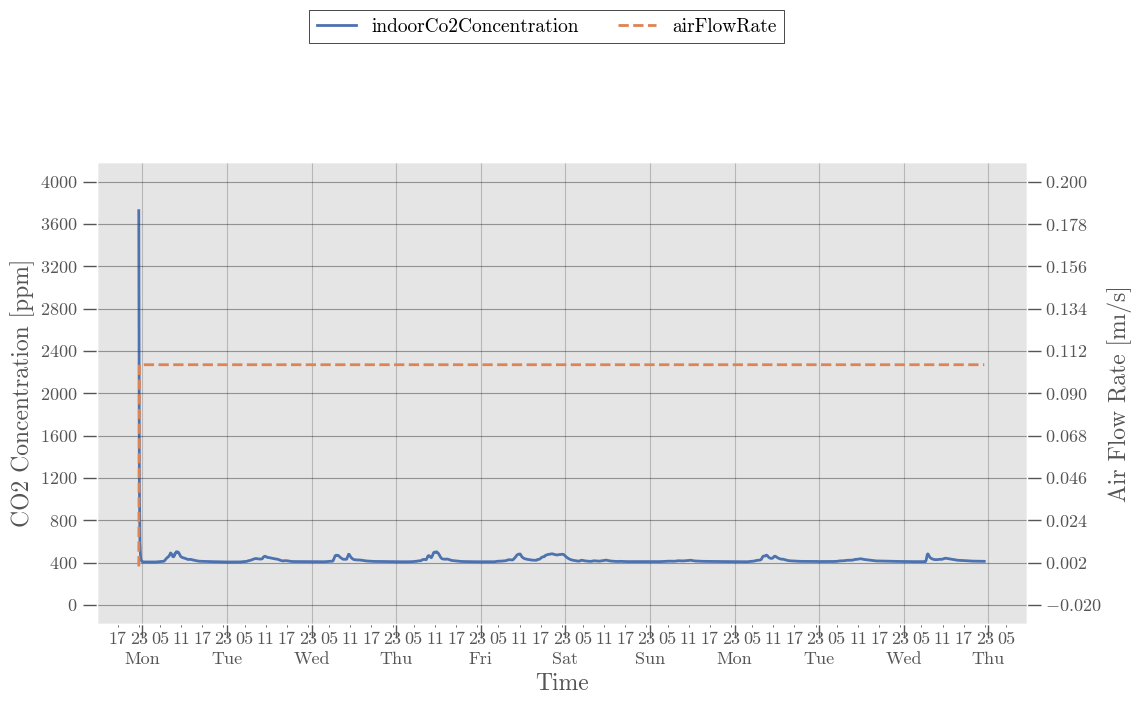

(<Figure size 1200x600 with 2 Axes>,
 [<Axes: xlabel='Time', ylabel='CO2 Concentration [ppm]'>,
  <Axes: ylabel='Air Flow Rate [m³/s]'>])

In [10]:
stepSize = 600  # Seconds
startTime = datetime.datetime(year=2023, month=11, day=27, hour=0, minute=0, second=0,
                                tzinfo=gettz("Europe/Copenhagen"))
endTime = datetime.datetime(year=2023, month=12, day=7, hour=0, minute=0, second=0,
                            tzinfo=gettz("Europe/Copenhagen"))

simulator = tb.Simulator()
simulator.simulate(model, startTime=startTime, endTime=endTime, stepSize=stepSize)
print("Simulation completed successfully!")

# Plot the results using plot_component
space_id = '[020B][020B_space_heater]'

# Temperature plot
plot.plot_component(
    simulator,
    components_1axis=[(space_id, 'indoorTemperature')],
    components_2axis=[(space_id, 'outdoorTemperature')],
    ylabel_1axis='Room Temperature [°C]',
    ylabel_2axis='Outdoor Temperature [°C]',
    show=True
)

# CO2 plot
plot.plot_component(
    simulator,
    components_1axis=[(space_id, 'indoorCo2Concentration')],
    components_2axis=[(space_id, 'airFlowRate')],
    ylabel_1axis='CO2 Concentration [ppm]',
    ylabel_2axis='Air Flow Rate [m³/s]',
    show=True
) 